# Embedding analysis

After having trained an autoencoder on the imaging data, we are now analyzing the learned embedding.

At the time being the autoencoder was trained only on a randomly subsampled set of control nuclei (20k) and the nuclei from the experiments where one of the 31 transcription factors were perturbed.

## 0. Environmental setup

In [1]:
import pandas as pd
import numpy as np
import umap.plot
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import time
import copy
import tqdm

In /usr/share/miniconda3/envs/image2reg/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/share/miniconda3/envs/image2reg/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/share/miniconda3/envs/image2reg/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/share/miniconda3/envs/image2reg/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import torch.utils.data as data_utils
use_cuda = True

torch.manual_seed(1234)


## 1. Read in data

We will first read in both the derived latent embeddings from the training, validation and test set (split 70-20-10) as well as the initial raw data which will be required to link the labels to the respective gene symbols.

In [3]:
nuclei_metadata = pd.read_csv("../data/experiments/preprocessing_transfer/pad_nuclei_64px_unet_seg/padded_nuclei_metadata.csv")

In [4]:
gene_label_to_gene_symbol = dict(zip(list(nuclei_metadata["gene_label"]), list(nuclei_metadata["gene_symbol"])))

In [5]:
gene_label_to_gene_symbol

{60: 'EIF4E',
 51: 'DKK1',
 12: 'ATF6',
 70: 'FURIN',
 107: 'MAPK8',
 27: 'CARD11',
 13: 'ATG16L1',
 184: 'TSC1',
 123: 'PAK1',
 190: 'XBP1',
 135: 'PRKAA1',
 101: 'MAP3K9',
 81: 'IKBKE',
 176: 'TGFBR1',
 154: 'RIPK1',
 63: 'EMPTY',
 142: 'PSENEN',
 24: 'BRAF',
 54: 'DVL1',
 125: 'PER1',
 58: 'EGLN1',
 114: 'MOS',
 23: 'BMPR1B',
 92: 'Luciferase',
 30: 'CCND1',
 56: 'DVL3',
 173: 'TBK1',
 130: 'PIK3R1',
 136: 'PRKACA',
 121: 'NOTCH1',
 49: 'DEPTOR',
 183: 'TRAF6',
 141: 'PRKCZ',
 137: 'PRKACB',
 138: 'PRKACG',
 50: 'DIABLO',
 37: 'CHUK',
 90: 'LRPPRC',
 159: 'SLIRP',
 112: 'MKNK1',
 145: 'RAF1',
 71: 'GLI1',
 46: 'CYLD',
 87: 'JAK2',
 132: 'PKIA',
 144: 'RAC1',
 74: 'HIF1A',
 170: 'STAT3',
 84: 'IRGM',
 0: 'ACVR1B',
 147: 'RBPJ',
 3: 'AKT1S1',
 191: 'XIAP',
 31: 'CCNE1',
 91: 'LacZ',
 158: 'SGK3',
 175: 'TGFB1',
 164: 'SMO',
 151: 'RHEB',
 115: 'MYD88',
 126: 'PHLPP1',
 186: 'VEGFC',
 69: 'FOXO1',
 133: 'PPARGC1A',
 155: 'RPS6KB1',
 5: 'AKT3',
 140: 'PRKCE',
 165: 'SMURF2',
 127: 'PIK3

In [6]:
train_latents = pd.read_csv("../data/experiments/ae_training_64px_unet_seg/test/image_latent_representations_train.csv.gz")

In [7]:
val_latents = pd.read_csv("../data/experiments/ae_training_64px_unet_seg/test/image_latent_representations_val.csv.gz")

In [8]:
#test_latents = pd.read_csv("../data/experiments/ae_training_64px_unet_seg/test/image_latent_representations_test.csv.gz")

In [9]:
# train_labels = np.array(train_latents.iloc[:,-1].map(gene_label_to_gene_symbol))
# train_latents = train_latents.loc[np.isin(train_labels, ["EMPTY", "ATF4"]),:]

In [10]:
train_labels = np.array(train_latents.iloc[:,-1].map(gene_label_to_gene_symbol))
train_latents = np.array(train_latents.iloc[:,:-1])

In [11]:
val_labels = np.array(val_latents.iloc[:,-1].map(gene_label_to_gene_symbol))
val_latents = np.array(val_latents.iloc[:,:-1])

In [12]:
test_labels = np.array(test_latents.iloc[:,-1].map(gene_label_to_gene_symbol))
test_latents = np.array(test_latents.iloc[:,:-1])

NameError: name 'test_latents' is not defined

## 2. Visualization of the latent space

Before further analyzing the latent space, we will quickly provide an overview of the latent space by plotting it. We will plot the latent space for the test samples to save some computation. Since, the reconstruction performance is highly comparable for all different subsets (training, validation and test) this we expect the test set to be a representative sample of the overall distribution.

In [15]:
sc = StandardScaler().fit(train_latents)

In [9]:
val_latents_norm = sc.transform(val_latents)
train_latents_nrom = sc.transform(train_latents)

In [14]:
mapper = umap.UMAP().fit(val_latents_norm)

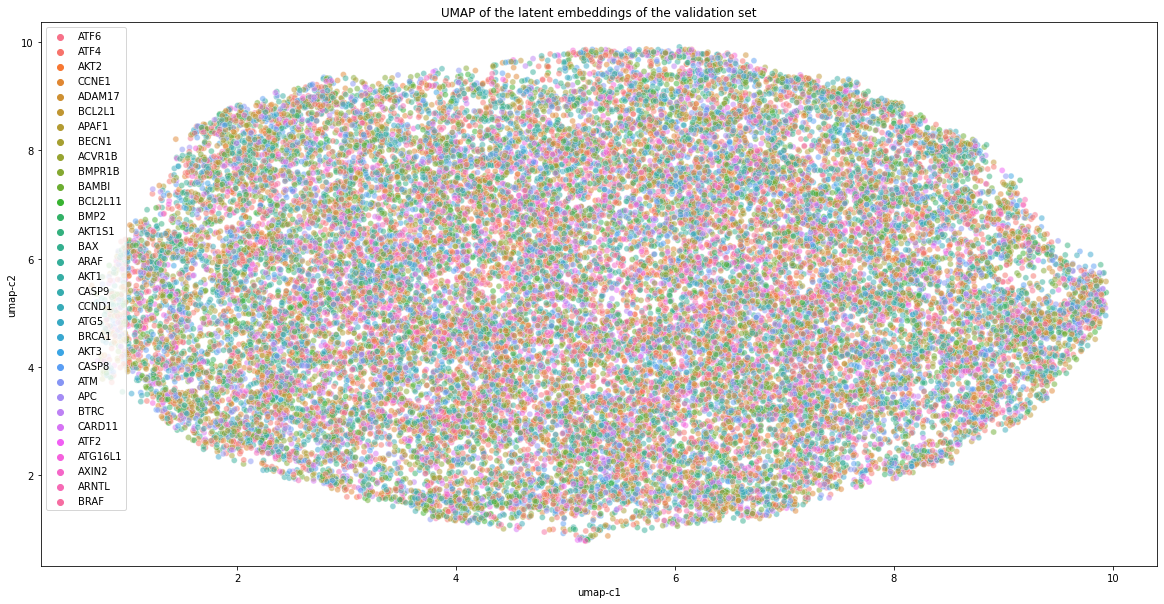

In [15]:
fig = plt.figure(figsize=[20,10])
sns.scatterplot(x=mapper.embedding_[:,0], y=mapper.embedding_[:,1], hue=val_labels, alpha=0.5)
plt.title("UMAP of the latent embeddings of the validation set")
plt.xlabel("umap-c1")
plt.ylabel("umap-c2")
plt.show()

## 3. Discriminative power of the embeddings

The above visualization does not show a clear separation of the different classes. We will further analyze this by training a linear classifier on the embeddings that we have derived. Thereby, we keep the splits and use the training, validation and test set embeddings as input respectively.

The linear classifier simply consists of a single layer MLP with no activation that is trained to minimize the CrossEntropyLoss.

In [13]:
# check if GPU is available and set the device accordingly
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  
torch.cuda.get_device_name(0)

'NVIDIA Quadro T2000'

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

sc = StandardScaler().fit(train_latents)
data_train = sc.transform(train_latents)
data_val = sc.transform(val_latents)
#data_test = sc.transform(test_latents)

le = LabelEncoder().fit(np.concatenate([train_labels, val_labels]))
label_train = le.transform(train_labels)
label_val = le.transform(val_labels)
#label_test = le.transform(test_labels)


print(np.array(data_train).shape)
print(np.array(label_train).shape)
print(np.array(data_val).shape)
print(np.array(label_val).shape)
# print(np.array(data_test).shape)
# print(np.array(label_test).shape)

# Note that from here on we expect GPU to be available, if that is not the case 
# use torch.xxxTensor instead of torch.cuda.xxxTensor

train_tensors = data_utils.TensorDataset(
    torch.cuda.FloatTensor(np.array(data_train)), 
    torch.cuda.LongTensor(np.array(label_train)))

train_loader = data_utils.DataLoader(train_tensors, 
                                     batch_size = 8, shuffle = True)

val_tensors = data_utils.TensorDataset(
    torch.cuda.FloatTensor(np.array(data_val)), 
    torch.cuda.LongTensor(np.array(label_val)))

val_loader = data_utils.DataLoader(val_tensors, 
                                   batch_size = 8, shuffle = False)

# test_tensors = data_utils.TensorDataset(
#     torch.cuda.FloatTensor(np.array(data_test)), 
#     torch.cuda.LongTensor(np.array(label_test)))

# test_loader = data_utils.DataLoader(test_tensors, 
#                                    batch_size = 32, shuffle = False)

#data_loaders_dict = {'train':train_loader, 'val':val_loader, 'test':test_loader}
data_loaders_dict = {'train':train_loader, 'val':val_loader}
data_loaders_dict

(110033, 2048)
(110033,)
(31439, 2048)
(31439,)


{'train': <torch.utils.data.dataloader.DataLoader at 0x7ff56afa1bb0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7ff56a3ba100>}

In [15]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=100):
    since = time.time()

    train_acc_history = []
    val_acc_history = []
    
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm.tqdm(range(num_epochs)):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.type(torch.FloatTensor).to(device)
                labels = labels.type(torch.LongTensor).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                  # Get model outputs and calculate loss
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)
                  _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase =="train":
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

            print('{} Loss: {:.6f} Acc: {:.6f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model if it has the best val accurary
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, 
                                                        time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history

In [16]:
seqnet = nn.Linear(2048, 32)
seqnet.cuda()
seqnet.to(device)
print(seqnet)

Linear(in_features=2048, out_features=32, bias=True)


In [17]:
from torch.optim import Adam
params_to_update = seqnet.parameters()
optimizer_ft = Adam(params_to_update, lr=1e-5)
criterion = nn.CrossEntropyLoss()

In [18]:
counts_train = np.unique(label_train, return_counts=True)[1]/len(label_train)
counts_val = np.unique(label_val, return_counts=True)[1]/len(label_val)
(counts_train, counts_val)

(array([0.01560441, 0.019685  , 0.0300728 , 0.04035153, 0.02404733,
        0.01963956, 0.01396854, 0.00952442, 0.03927913, 0.0217662 ,
        0.01105123, 0.12723456, 0.02019394, 0.03127244, 0.01481374,
        0.03662538, 0.02712823, 0.03777958, 0.02032118, 0.03877928,
        0.03782502, 0.03630729, 0.01957595, 0.03831578, 0.01302337,
        0.02078467, 0.01891251, 0.03516218, 0.05265693, 0.02913671,
        0.03248116, 0.06668   ]),
 array([0.01561755, 0.01968892, 0.03005821, 0.04033207, 0.02404657,
        0.01965711, 0.01396355, 0.00951048, 0.03928242, 0.02175642,
        0.01103725, 0.12723051, 0.02019784, 0.0312669 , 0.01482235,
        0.03664239, 0.02713191, 0.03778746, 0.02032507, 0.0387735 ,
        0.03781927, 0.03632431, 0.01956169, 0.03829638, 0.01304113,
        0.02080219, 0.01892554, 0.03517924, 0.05264162, 0.02913579,
        0.03247559, 0.06666879]))

In [19]:
num_epochs=300
seqnet_fit, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_model(seqnet, data_loaders_dict, 
                             criterion, optimizer_ft, 
                             num_epochs=num_epochs)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0/299
----------
train Loss: 3.540349 Acc: 0.039697


  0%|          | 1/300 [00:17<1:25:22, 17.13s/it]

val Loss: 3.501261 Acc: 0.047139

Epoch 1/299
----------
train Loss: 3.454533 Acc: 0.055847


  1%|          | 2/300 [00:33<1:23:09, 16.74s/it]

val Loss: 3.463950 Acc: 0.053691

Epoch 2/299
----------
train Loss: 3.407183 Acc: 0.065389


  1%|          | 3/300 [00:50<1:23:13, 16.81s/it]

val Loss: 3.439084 Acc: 0.058940

Epoch 3/299
----------
train Loss: 3.371977 Acc: 0.074714


  1%|▏         | 4/300 [01:08<1:26:13, 17.48s/it]

val Loss: 3.420646 Acc: 0.061929

Epoch 4/299
----------
train Loss: 3.343945 Acc: 0.081585


  2%|▏         | 5/300 [01:26<1:25:22, 17.37s/it]

val Loss: 3.406424 Acc: 0.066605

Epoch 5/299
----------
train Loss: 3.320387 Acc: 0.087819


  2%|▏         | 6/300 [01:43<1:24:56, 17.33s/it]

val Loss: 3.394437 Acc: 0.069881

Epoch 6/299
----------
train Loss: 3.300307 Acc: 0.093436


  2%|▏         | 7/300 [02:00<1:24:32, 17.31s/it]

val Loss: 3.384164 Acc: 0.072999

Epoch 7/299
----------
train Loss: 3.283008 Acc: 0.098825


  3%|▎         | 8/300 [02:18<1:24:26, 17.35s/it]

val Loss: 3.375591 Acc: 0.077420

Epoch 8/299
----------
train Loss: 3.267720 Acc: 0.103751


  3%|▎         | 9/300 [02:34<1:23:06, 17.14s/it]

val Loss: 3.368200 Acc: 0.081268

Epoch 9/299
----------
train Loss: 3.254476 Acc: 0.108695


  3%|▎         | 10/300 [02:51<1:22:49, 17.14s/it]

val Loss: 3.361973 Acc: 0.084481

Epoch 10/299
----------
train Loss: 3.242633 Acc: 0.112466


  4%|▎         | 11/300 [03:08<1:22:16, 17.08s/it]

val Loss: 3.356576 Acc: 0.087821

Epoch 11/299
----------
train Loss: 3.232258 Acc: 0.115992


  4%|▍         | 12/300 [03:25<1:21:08, 16.91s/it]

val Loss: 3.352575 Acc: 0.091097

Epoch 12/299
----------
train Loss: 3.222979 Acc: 0.118801


  4%|▍         | 13/300 [03:41<1:20:14, 16.78s/it]

val Loss: 3.348580 Acc: 0.093673

Epoch 13/299
----------
train Loss: 3.214764 Acc: 0.121091


  5%|▍         | 14/300 [03:58<1:20:10, 16.82s/it]

val Loss: 3.345403 Acc: 0.096886

Epoch 14/299
----------
train Loss: 3.207654 Acc: 0.123163


  5%|▌         | 15/300 [04:15<1:19:42, 16.78s/it]

val Loss: 3.343637 Acc: 0.100289

Epoch 15/299
----------
train Loss: 3.201294 Acc: 0.124008


  5%|▌         | 16/300 [04:31<1:18:56, 16.68s/it]

val Loss: 3.341407 Acc: 0.102039

Epoch 16/299
----------
train Loss: 3.195488 Acc: 0.126617


  6%|▌         | 17/300 [04:48<1:19:06, 16.77s/it]

val Loss: 3.340391 Acc: 0.103089

Epoch 17/299
----------
train Loss: 3.190382 Acc: 0.127825


  6%|▌         | 18/300 [05:05<1:19:02, 16.82s/it]

val Loss: 3.339108 Acc: 0.104870

Epoch 18/299
----------
train Loss: 3.185829 Acc: 0.128761


  6%|▋         | 19/300 [05:22<1:17:56, 16.64s/it]

val Loss: 3.338723 Acc: 0.106715

Epoch 19/299
----------
train Loss: 3.181609 Acc: 0.129243


  7%|▋         | 20/300 [05:38<1:17:24, 16.59s/it]

val Loss: 3.337851 Acc: 0.107573

Epoch 20/299
----------
train Loss: 3.178012 Acc: 0.129788


  7%|▋         | 21/300 [05:55<1:16:59, 16.56s/it]

val Loss: 3.338001 Acc: 0.109673

Epoch 21/299
----------
train Loss: 3.174512 Acc: 0.130933


  7%|▋         | 22/300 [06:11<1:16:59, 16.62s/it]

val Loss: 3.337784 Acc: 0.110277

Epoch 22/299
----------
train Loss: 3.171590 Acc: 0.131252


  8%|▊         | 23/300 [06:27<1:16:08, 16.49s/it]

val Loss: 3.337445 Acc: 0.110309

Epoch 23/299
----------
train Loss: 3.168678 Acc: 0.131979


  8%|▊         | 24/300 [06:43<1:14:01, 16.09s/it]

val Loss: 3.338525 Acc: 0.111581

Epoch 24/299
----------
train Loss: 3.166328 Acc: 0.132188


  8%|▊         | 25/300 [06:58<1:12:26, 15.81s/it]

val Loss: 3.338807 Acc: 0.111995

Epoch 25/299
----------
train Loss: 3.163955 Acc: 0.131906


  9%|▊         | 26/300 [07:13<1:11:42, 15.70s/it]

val Loss: 3.338027 Acc: 0.113108

Epoch 26/299
----------
train Loss: 3.161851 Acc: 0.132887


  9%|▉         | 27/300 [07:29<1:10:51, 15.57s/it]

val Loss: 3.338960 Acc: 0.113394

Epoch 27/299
----------
train Loss: 3.159776 Acc: 0.132860


  9%|▉         | 28/300 [07:44<1:10:52, 15.63s/it]

val Loss: 3.340407 Acc: 0.113776

Epoch 28/299
----------
train Loss: 3.158007 Acc: 0.132169


 10%|▉         | 29/300 [08:01<1:11:29, 15.83s/it]

val Loss: 3.340636 Acc: 0.113140

Epoch 29/299
----------
train Loss: 3.156276 Acc: 0.133087


 10%|█         | 30/300 [08:17<1:11:27, 15.88s/it]

val Loss: 3.341401 Acc: 0.113967

Epoch 30/299
----------
train Loss: 3.154587 Acc: 0.133242


 10%|█         | 31/300 [08:33<1:11:59, 16.06s/it]

val Loss: 3.342240 Acc: 0.114444

Epoch 31/299
----------
train Loss: 3.153169 Acc: 0.132942


 11%|█         | 32/300 [08:49<1:11:37, 16.03s/it]

val Loss: 3.342895 Acc: 0.115016

Epoch 32/299
----------
train Loss: 3.151619 Acc: 0.133914


 11%|█         | 33/300 [09:04<1:10:34, 15.86s/it]

val Loss: 3.343357 Acc: 0.114476

Epoch 33/299
----------
train Loss: 3.150288 Acc: 0.133951


 11%|█▏        | 34/300 [09:21<1:10:47, 15.97s/it]

val Loss: 3.344123 Acc: 0.115080

Epoch 34/299
----------
train Loss: 3.149093 Acc: 0.133533


 12%|█▏        | 35/300 [09:37<1:10:27, 15.95s/it]

val Loss: 3.344793 Acc: 0.114953

Epoch 35/299
----------
train Loss: 3.147956 Acc: 0.133905


 12%|█▏        | 36/300 [09:53<1:10:28, 16.02s/it]

val Loss: 3.345387 Acc: 0.115271

Epoch 36/299
----------
train Loss: 3.146723 Acc: 0.133733


 12%|█▏        | 37/300 [10:08<1:09:36, 15.88s/it]

val Loss: 3.346116 Acc: 0.114985

Epoch 37/299
----------
train Loss: 3.145507 Acc: 0.134123


 13%|█▎        | 38/300 [10:24<1:09:03, 15.82s/it]

val Loss: 3.347006 Acc: 0.114507

Epoch 38/299
----------
train Loss: 3.144613 Acc: 0.134532


 13%|█▎        | 39/300 [10:40<1:08:44, 15.80s/it]

val Loss: 3.347846 Acc: 0.115812

Epoch 39/299
----------
train Loss: 3.143504 Acc: 0.134841


 13%|█▎        | 40/300 [10:55<1:07:58, 15.69s/it]

val Loss: 3.348445 Acc: 0.115875

Epoch 40/299
----------
train Loss: 3.142566 Acc: 0.134469


 14%|█▎        | 41/300 [11:11<1:08:09, 15.79s/it]

val Loss: 3.349389 Acc: 0.115239

Epoch 41/299
----------
train Loss: 3.141592 Acc: 0.134396


 14%|█▍        | 42/300 [11:27<1:07:21, 15.67s/it]

val Loss: 3.350065 Acc: 0.115303

Epoch 42/299
----------
train Loss: 3.140757 Acc: 0.134932


 14%|█▍        | 43/300 [11:41<1:06:04, 15.43s/it]

val Loss: 3.351169 Acc: 0.115207

Epoch 43/299
----------
train Loss: 3.139814 Acc: 0.134887


 15%|█▍        | 44/300 [11:57<1:05:52, 15.44s/it]

val Loss: 3.352181 Acc: 0.115334

Epoch 44/299
----------
train Loss: 3.139107 Acc: 0.135023


 15%|█▌        | 45/300 [12:12<1:05:27, 15.40s/it]

val Loss: 3.352549 Acc: 0.115971

Epoch 45/299
----------
train Loss: 3.138166 Acc: 0.135059


 15%|█▌        | 46/300 [12:28<1:05:58, 15.58s/it]

val Loss: 3.353717 Acc: 0.115144

Epoch 46/299
----------
train Loss: 3.137499 Acc: 0.135005


 16%|█▌        | 47/300 [12:44<1:06:15, 15.72s/it]

val Loss: 3.353919 Acc: 0.115430

Epoch 47/299
----------
train Loss: 3.136804 Acc: 0.135096


 16%|█▌        | 48/300 [13:00<1:05:41, 15.64s/it]

val Loss: 3.354359 Acc: 0.115430

Epoch 48/299
----------
train Loss: 3.136054 Acc: 0.134760


 16%|█▋        | 49/300 [13:15<1:05:34, 15.68s/it]

val Loss: 3.355251 Acc: 0.115366

Epoch 49/299
----------
train Loss: 3.135204 Acc: 0.135169


 17%|█▋        | 50/300 [13:31<1:05:18, 15.67s/it]

val Loss: 3.355802 Acc: 0.115144

Epoch 50/299
----------
train Loss: 3.134691 Acc: 0.135650


 17%|█▋        | 51/300 [13:47<1:05:06, 15.69s/it]

val Loss: 3.357176 Acc: 0.115366

Epoch 51/299
----------
train Loss: 3.134047 Acc: 0.135578


 17%|█▋        | 52/300 [14:02<1:04:26, 15.59s/it]

val Loss: 3.357366 Acc: 0.115462

Epoch 52/299
----------
train Loss: 3.133389 Acc: 0.135868


 18%|█▊        | 53/300 [14:18<1:03:45, 15.49s/it]

val Loss: 3.357666 Acc: 0.115334

Epoch 53/299
----------
train Loss: 3.132749 Acc: 0.135787


 18%|█▊        | 54/300 [14:34<1:04:30, 15.73s/it]

val Loss: 3.358820 Acc: 0.115239

Epoch 54/299
----------
train Loss: 3.132071 Acc: 0.135496


 18%|█▊        | 55/300 [14:49<1:03:51, 15.64s/it]

val Loss: 3.358614 Acc: 0.115271

Epoch 55/299
----------
train Loss: 3.131553 Acc: 0.135614


 19%|█▊        | 56/300 [15:06<1:04:26, 15.85s/it]

val Loss: 3.359271 Acc: 0.115653

Epoch 56/299
----------
train Loss: 3.130930 Acc: 0.135696


 19%|█▉        | 57/300 [15:22<1:04:57, 16.04s/it]

val Loss: 3.360047 Acc: 0.114348

Epoch 57/299
----------
train Loss: 3.130365 Acc: 0.135805


 19%|█▉        | 58/300 [15:38<1:04:31, 16.00s/it]

val Loss: 3.360720 Acc: 0.114826

Epoch 58/299
----------
train Loss: 3.129750 Acc: 0.136314


 20%|█▉        | 59/300 [15:55<1:05:26, 16.29s/it]

val Loss: 3.361441 Acc: 0.114889

Epoch 59/299
----------
train Loss: 3.129320 Acc: 0.136086


 20%|██        | 60/300 [16:11<1:05:02, 16.26s/it]

val Loss: 3.362145 Acc: 0.115398

Epoch 60/299
----------
train Loss: 3.128752 Acc: 0.136150


 20%|██        | 61/300 [16:27<1:04:17, 16.14s/it]

val Loss: 3.362056 Acc: 0.114285

Epoch 61/299
----------
train Loss: 3.128215 Acc: 0.136423


 21%|██        | 62/300 [16:43<1:04:17, 16.21s/it]

val Loss: 3.363187 Acc: 0.115589

Epoch 62/299
----------
train Loss: 3.127781 Acc: 0.136259


 21%|██        | 63/300 [17:00<1:04:18, 16.28s/it]

val Loss: 3.363427 Acc: 0.115144

Epoch 63/299
----------
train Loss: 3.127250 Acc: 0.136786


 21%|██▏       | 64/300 [17:15<1:02:57, 16.01s/it]

val Loss: 3.364153 Acc: 0.115207

Epoch 64/299
----------
train Loss: 3.126730 Acc: 0.136077


 22%|██▏       | 65/300 [17:31<1:02:58, 16.08s/it]

val Loss: 3.364912 Acc: 0.114539

Epoch 65/299
----------
train Loss: 3.126204 Acc: 0.136305


 22%|██▏       | 66/300 [17:47<1:02:19, 15.98s/it]

val Loss: 3.365071 Acc: 0.114253

Epoch 66/299
----------
train Loss: 3.125857 Acc: 0.136050


 22%|██▏       | 67/300 [18:03<1:02:13, 16.02s/it]

val Loss: 3.365252 Acc: 0.113935

Epoch 67/299
----------
train Loss: 3.125351 Acc: 0.136477


 23%|██▎       | 68/300 [18:20<1:02:17, 16.11s/it]

val Loss: 3.366303 Acc: 0.114380

Epoch 68/299
----------
train Loss: 3.124999 Acc: 0.136314


 23%|██▎       | 69/300 [18:35<1:01:34, 15.99s/it]

val Loss: 3.366870 Acc: 0.114412

Epoch 69/299
----------
train Loss: 3.124578 Acc: 0.136386


 23%|██▎       | 70/300 [18:52<1:01:43, 16.10s/it]

val Loss: 3.367058 Acc: 0.114348

Epoch 70/299
----------
train Loss: 3.124075 Acc: 0.136386


 24%|██▎       | 71/300 [19:07<1:01:07, 16.01s/it]

val Loss: 3.368032 Acc: 0.114794

Epoch 71/299
----------
train Loss: 3.123838 Acc: 0.136259


 24%|██▍       | 72/300 [19:23<1:00:27, 15.91s/it]

val Loss: 3.367417 Acc: 0.114126

Epoch 72/299
----------
train Loss: 3.123326 Acc: 0.137013


 24%|██▍       | 73/300 [19:39<1:00:35, 16.01s/it]

val Loss: 3.368474 Acc: 0.114380

Epoch 73/299
----------
train Loss: 3.122981 Acc: 0.136841


 25%|██▍       | 74/300 [19:55<1:00:10, 15.97s/it]

val Loss: 3.368921 Acc: 0.113999

Epoch 74/299
----------
train Loss: 3.122521 Acc: 0.136913


 25%|██▌       | 75/300 [20:12<1:00:12, 16.06s/it]

val Loss: 3.369340 Acc: 0.114189

Epoch 75/299
----------
train Loss: 3.122143 Acc: 0.137322


 25%|██▌       | 76/300 [20:27<59:42, 16.00s/it]  

val Loss: 3.369636 Acc: 0.113839

Epoch 76/299
----------
train Loss: 3.121681 Acc: 0.136759


 26%|██▌       | 77/300 [20:43<59:20, 15.96s/it]

val Loss: 3.370307 Acc: 0.113649

Epoch 77/299
----------
train Loss: 3.121469 Acc: 0.137059


 26%|██▌       | 78/300 [20:59<59:18, 16.03s/it]

val Loss: 3.370422 Acc: 0.115016

Epoch 78/299
----------
train Loss: 3.121004 Acc: 0.136968


 26%|██▋       | 79/300 [21:16<59:05, 16.04s/it]

val Loss: 3.370768 Acc: 0.114412

Epoch 79/299
----------
train Loss: 3.120685 Acc: 0.136868


 27%|██▋       | 80/300 [21:31<58:39, 16.00s/it]

val Loss: 3.371576 Acc: 0.113903

Epoch 80/299
----------
train Loss: 3.120307 Acc: 0.137268


 27%|██▋       | 81/300 [21:48<58:32, 16.04s/it]

val Loss: 3.372071 Acc: 0.113299

Epoch 81/299
----------
train Loss: 3.120023 Acc: 0.137150


 27%|██▋       | 82/300 [22:03<57:49, 15.92s/it]

val Loss: 3.372117 Acc: 0.114380

Epoch 82/299
----------
train Loss: 3.119667 Acc: 0.137113


 28%|██▊       | 83/300 [22:20<58:18, 16.12s/it]

val Loss: 3.372809 Acc: 0.114062

Epoch 83/299
----------
train Loss: 3.119290 Acc: 0.137241


 28%|██▊       | 84/300 [22:36<58:04, 16.13s/it]

val Loss: 3.373569 Acc: 0.114030

Epoch 84/299
----------
train Loss: 3.118908 Acc: 0.137431


 28%|██▊       | 85/300 [22:52<57:32, 16.06s/it]

val Loss: 3.373659 Acc: 0.114030

Epoch 85/299
----------
train Loss: 3.118600 Acc: 0.137450


 29%|██▊       | 86/300 [23:08<57:32, 16.13s/it]

val Loss: 3.373708 Acc: 0.113935

Epoch 86/299
----------
train Loss: 3.118229 Acc: 0.137150


 29%|██▉       | 87/300 [23:24<57:14, 16.12s/it]

val Loss: 3.374183 Acc: 0.113839

Epoch 87/299
----------
train Loss: 3.117964 Acc: 0.137431


 29%|██▉       | 88/300 [23:40<56:49, 16.08s/it]

val Loss: 3.375288 Acc: 0.113967

Epoch 88/299
----------
train Loss: 3.117650 Acc: 0.137195


 30%|██▉       | 89/300 [23:57<56:59, 16.21s/it]

val Loss: 3.375213 Acc: 0.112917

Epoch 89/299
----------
train Loss: 3.117384 Acc: 0.137468


 30%|███       | 90/300 [24:13<56:57, 16.27s/it]

val Loss: 3.375484 Acc: 0.113140

Epoch 90/299
----------
train Loss: 3.117024 Acc: 0.137577


 30%|███       | 91/300 [24:29<56:28, 16.21s/it]

val Loss: 3.375878 Acc: 0.113490

Epoch 91/299
----------
train Loss: 3.116762 Acc: 0.137531


 31%|███       | 92/300 [24:45<55:51, 16.11s/it]

val Loss: 3.376011 Acc: 0.113585

Epoch 92/299
----------
train Loss: 3.116456 Acc: 0.138186


 31%|███       | 93/300 [25:02<55:58, 16.23s/it]

val Loss: 3.376953 Acc: 0.113394

Epoch 93/299
----------
train Loss: 3.116229 Acc: 0.138022


 31%|███▏      | 94/300 [25:18<55:33, 16.18s/it]

val Loss: 3.376917 Acc: 0.113490

Epoch 94/299
----------
train Loss: 3.115964 Acc: 0.137222


 32%|███▏      | 95/300 [25:34<55:19, 16.19s/it]

val Loss: 3.376909 Acc: 0.113299

Epoch 95/299
----------
train Loss: 3.115508 Acc: 0.138667


 32%|███▏      | 96/300 [25:50<55:24, 16.30s/it]

val Loss: 3.377718 Acc: 0.112822

Epoch 96/299
----------
train Loss: 3.115330 Acc: 0.138540


 32%|███▏      | 97/300 [26:06<54:30, 16.11s/it]

val Loss: 3.378049 Acc: 0.113362

Epoch 97/299
----------
train Loss: 3.115093 Acc: 0.138040


 33%|███▎      | 98/300 [26:23<54:49, 16.28s/it]

val Loss: 3.378603 Acc: 0.112917

Epoch 98/299
----------
train Loss: 3.114765 Acc: 0.137931


 33%|███▎      | 99/300 [26:39<54:52, 16.38s/it]

val Loss: 3.378433 Acc: 0.113458

Epoch 99/299
----------
train Loss: 3.114406 Acc: 0.137813


 33%|███▎      | 100/300 [26:55<54:18, 16.29s/it]

val Loss: 3.379256 Acc: 0.113553

Epoch 100/299
----------
train Loss: 3.114202 Acc: 0.138504


 34%|███▎      | 101/300 [27:11<53:38, 16.17s/it]

val Loss: 3.379354 Acc: 0.113935

Epoch 101/299
----------
train Loss: 3.113963 Acc: 0.138149


 34%|███▍      | 102/300 [27:28<53:39, 16.26s/it]

val Loss: 3.380155 Acc: 0.113235

Epoch 102/299
----------
train Loss: 3.113741 Acc: 0.138313


 34%|███▍      | 103/300 [27:44<53:02, 16.15s/it]

val Loss: 3.379694 Acc: 0.114158

Epoch 103/299
----------
train Loss: 3.113501 Acc: 0.137831


 35%|███▍      | 104/300 [28:00<53:03, 16.24s/it]

val Loss: 3.379973 Acc: 0.113044

Epoch 104/299
----------
train Loss: 3.113090 Acc: 0.138349


 35%|███▌      | 105/300 [28:16<52:49, 16.25s/it]

val Loss: 3.380320 Acc: 0.112440

Epoch 105/299
----------
train Loss: 3.112973 Acc: 0.138422


 35%|███▌      | 106/300 [28:32<52:01, 16.09s/it]

val Loss: 3.380600 Acc: 0.113617

Epoch 106/299
----------
train Loss: 3.112727 Acc: 0.138313


 36%|███▌      | 107/300 [28:49<52:01, 16.17s/it]

val Loss: 3.381074 Acc: 0.113172

Epoch 107/299
----------
train Loss: 3.112456 Acc: 0.138177


 36%|███▌      | 108/300 [29:05<51:47, 16.18s/it]

val Loss: 3.381121 Acc: 0.113140

Epoch 108/299
----------
train Loss: 3.112152 Acc: 0.138404


 36%|███▋      | 109/300 [29:21<51:11, 16.08s/it]

val Loss: 3.381308 Acc: 0.112949

Epoch 109/299
----------
train Loss: 3.111938 Acc: 0.138395


 37%|███▋      | 110/300 [29:37<51:08, 16.15s/it]

val Loss: 3.381785 Acc: 0.112726

Epoch 110/299
----------
train Loss: 3.111666 Acc: 0.138177


 37%|███▋      | 111/300 [29:53<51:02, 16.20s/it]

val Loss: 3.382366 Acc: 0.112726

Epoch 111/299
----------
train Loss: 3.111485 Acc: 0.138822


 37%|███▋      | 112/300 [30:09<50:44, 16.20s/it]

val Loss: 3.383030 Acc: 0.112981

Epoch 112/299
----------
train Loss: 3.111187 Acc: 0.138731


 38%|███▊      | 113/300 [30:26<50:23, 16.17s/it]

val Loss: 3.383251 Acc: 0.113203

Epoch 113/299
----------
train Loss: 3.111007 Acc: 0.139131


 38%|███▊      | 114/300 [30:41<49:30, 15.97s/it]

val Loss: 3.382926 Acc: 0.113013

Epoch 114/299
----------
train Loss: 3.110795 Acc: 0.138504


 38%|███▊      | 115/300 [30:57<49:03, 15.91s/it]

val Loss: 3.383412 Acc: 0.112790

Epoch 115/299
----------
train Loss: 3.110508 Acc: 0.138531


 39%|███▊      | 116/300 [31:12<48:33, 15.83s/it]

val Loss: 3.383232 Acc: 0.112822

Epoch 116/299
----------
train Loss: 3.110411 Acc: 0.138686


 39%|███▉      | 117/300 [31:29<48:33, 15.92s/it]

val Loss: 3.383684 Acc: 0.113140

Epoch 117/299
----------
train Loss: 3.110155 Acc: 0.138813


 39%|███▉      | 118/300 [31:44<47:45, 15.74s/it]

val Loss: 3.383654 Acc: 0.112853

Epoch 118/299
----------
train Loss: 3.109900 Acc: 0.138677


 40%|███▉      | 119/300 [32:00<47:44, 15.83s/it]

val Loss: 3.384490 Acc: 0.112567

Epoch 119/299
----------
train Loss: 3.109736 Acc: 0.138995


 40%|████      | 120/300 [32:16<47:15, 15.75s/it]

val Loss: 3.384718 Acc: 0.112567

Epoch 120/299
----------
train Loss: 3.109546 Acc: 0.138958


 40%|████      | 121/300 [32:31<47:03, 15.77s/it]

val Loss: 3.384348 Acc: 0.112949

Epoch 121/299
----------
train Loss: 3.109259 Acc: 0.138677


 41%|████      | 122/300 [32:47<46:34, 15.70s/it]

val Loss: 3.384671 Acc: 0.112376

Epoch 122/299
----------
train Loss: 3.109117 Acc: 0.139140


 41%|████      | 123/300 [33:03<46:28, 15.76s/it]

val Loss: 3.385250 Acc: 0.112981

Epoch 123/299
----------
train Loss: 3.108900 Acc: 0.138849


 41%|████▏     | 124/300 [33:18<45:47, 15.61s/it]

val Loss: 3.385565 Acc: 0.112154

Epoch 124/299
----------
train Loss: 3.108647 Acc: 0.139195


 42%|████▏     | 125/300 [33:34<46:01, 15.78s/it]

val Loss: 3.386141 Acc: 0.111899

Epoch 125/299
----------
train Loss: 3.108380 Acc: 0.139113


 42%|████▏     | 126/300 [33:51<46:15, 15.95s/it]

val Loss: 3.386889 Acc: 0.112408

Epoch 126/299
----------
train Loss: 3.108334 Acc: 0.139349


 42%|████▏     | 127/300 [34:06<45:48, 15.89s/it]

val Loss: 3.386582 Acc: 0.112535

Epoch 127/299
----------
train Loss: 3.108035 Acc: 0.139204


 43%|████▎     | 128/300 [34:22<45:18, 15.81s/it]

val Loss: 3.386398 Acc: 0.112663

Epoch 128/299
----------
train Loss: 3.107833 Acc: 0.139295


 43%|████▎     | 129/300 [34:38<45:22, 15.92s/it]

val Loss: 3.386878 Acc: 0.113426

Epoch 129/299
----------
train Loss: 3.107748 Acc: 0.138913


 43%|████▎     | 130/300 [34:54<44:41, 15.78s/it]

val Loss: 3.387012 Acc: 0.112090

Epoch 130/299
----------
train Loss: 3.107504 Acc: 0.138840


 44%|████▎     | 131/300 [35:10<44:46, 15.90s/it]

val Loss: 3.387252 Acc: 0.112472

Epoch 131/299
----------
train Loss: 3.107314 Acc: 0.139504


 44%|████▍     | 132/300 [35:25<44:16, 15.81s/it]

val Loss: 3.387398 Acc: 0.112376

Epoch 132/299
----------
train Loss: 3.107098 Acc: 0.139249


 44%|████▍     | 133/300 [35:41<43:54, 15.77s/it]

val Loss: 3.387677 Acc: 0.111995

Epoch 133/299
----------
train Loss: 3.106919 Acc: 0.139267


 45%|████▍     | 134/300 [35:57<44:11, 15.97s/it]

val Loss: 3.387824 Acc: 0.112058

Epoch 134/299
----------
train Loss: 3.106868 Acc: 0.139604


 45%|████▌     | 135/300 [36:13<43:41, 15.89s/it]

val Loss: 3.388519 Acc: 0.112440

Epoch 135/299
----------
train Loss: 3.106475 Acc: 0.139376


 45%|████▌     | 136/300 [36:29<43:07, 15.78s/it]

val Loss: 3.387926 Acc: 0.112472

Epoch 136/299
----------
train Loss: 3.106326 Acc: 0.139095


 46%|████▌     | 137/300 [36:45<43:18, 15.94s/it]

val Loss: 3.388688 Acc: 0.112472

Epoch 137/299
----------
train Loss: 3.106157 Acc: 0.139385


 46%|████▌     | 138/300 [37:01<42:42, 15.82s/it]

val Loss: 3.389080 Acc: 0.111772

Epoch 138/299
----------
train Loss: 3.105961 Acc: 0.139304


 46%|████▋     | 139/300 [37:16<42:22, 15.79s/it]

val Loss: 3.389170 Acc: 0.112313

Epoch 139/299
----------
train Loss: 3.105876 Acc: 0.139640


 47%|████▋     | 140/300 [37:32<41:52, 15.70s/it]

val Loss: 3.389192 Acc: 0.111231

Epoch 140/299
----------
train Loss: 3.105509 Acc: 0.139985


 47%|████▋     | 141/300 [37:48<41:47, 15.77s/it]

val Loss: 3.389751 Acc: 0.112313

Epoch 141/299
----------
train Loss: 3.105494 Acc: 0.139467


 47%|████▋     | 142/300 [38:04<42:14, 16.04s/it]

val Loss: 3.389706 Acc: 0.112058

Epoch 142/299
----------
train Loss: 3.105323 Acc: 0.140176


 48%|████▊     | 143/300 [38:20<41:34, 15.89s/it]

val Loss: 3.389631 Acc: 0.111677

Epoch 143/299
----------
train Loss: 3.104979 Acc: 0.139876


 48%|████▊     | 144/300 [38:35<40:53, 15.73s/it]

val Loss: 3.390087 Acc: 0.112154

Epoch 144/299
----------
train Loss: 3.105010 Acc: 0.140076


 48%|████▊     | 145/300 [38:51<40:59, 15.87s/it]

val Loss: 3.390614 Acc: 0.112154

Epoch 145/299
----------
train Loss: 3.104800 Acc: 0.139885


 49%|████▊     | 146/300 [39:07<40:50, 15.91s/it]

val Loss: 3.390455 Acc: 0.111518

Epoch 146/299
----------
train Loss: 3.104525 Acc: 0.139367


 49%|████▉     | 147/300 [39:23<40:19, 15.81s/it]

val Loss: 3.391185 Acc: 0.112376

Epoch 147/299
----------
train Loss: 3.104465 Acc: 0.140758


 49%|████▉     | 148/300 [39:39<40:06, 15.83s/it]

val Loss: 3.391430 Acc: 0.112345

Epoch 148/299
----------
train Loss: 3.104181 Acc: 0.139585


 50%|████▉     | 149/300 [39:55<39:54, 15.86s/it]

val Loss: 3.391201 Acc: 0.111454

Epoch 149/299
----------
train Loss: 3.104076 Acc: 0.139613


 50%|█████     | 150/300 [40:11<39:53, 15.96s/it]

val Loss: 3.391233 Acc: 0.112535

Epoch 150/299
----------
train Loss: 3.103943 Acc: 0.140013


 50%|█████     | 151/300 [40:26<39:16, 15.82s/it]

val Loss: 3.391383 Acc: 0.111867

Epoch 151/299
----------
train Loss: 3.103874 Acc: 0.140040


 51%|█████     | 152/300 [40:43<39:10, 15.88s/it]

val Loss: 3.391554 Acc: 0.112217

Epoch 152/299
----------
train Loss: 3.103566 Acc: 0.140367


 51%|█████     | 153/300 [40:58<38:44, 15.82s/it]

val Loss: 3.391730 Acc: 0.111613

Epoch 153/299
----------
train Loss: 3.103466 Acc: 0.140340


 51%|█████▏    | 154/300 [41:14<38:34, 15.85s/it]

val Loss: 3.391870 Acc: 0.111009

Epoch 154/299
----------
train Loss: 3.103326 Acc: 0.140267


 52%|█████▏    | 155/300 [41:30<38:23, 15.89s/it]

val Loss: 3.392211 Acc: 0.111104

Epoch 155/299
----------
train Loss: 3.103243 Acc: 0.140231


 52%|█████▏    | 156/300 [41:46<37:50, 15.77s/it]

val Loss: 3.392244 Acc: 0.111740

Epoch 156/299
----------
train Loss: 3.103016 Acc: 0.140485


 52%|█████▏    | 157/300 [42:01<37:39, 15.80s/it]

val Loss: 3.392162 Acc: 0.111645

Epoch 157/299
----------
train Loss: 3.102808 Acc: 0.140149


 53%|█████▎    | 158/300 [42:17<37:11, 15.71s/it]

val Loss: 3.392788 Acc: 0.111295

Epoch 158/299
----------
train Loss: 3.102662 Acc: 0.140113


 53%|█████▎    | 159/300 [42:33<37:09, 15.81s/it]

val Loss: 3.392587 Acc: 0.111867

Epoch 159/299
----------
train Loss: 3.102497 Acc: 0.140167


 53%|█████▎    | 160/300 [42:49<36:46, 15.76s/it]

val Loss: 3.392879 Acc: 0.111422

Epoch 160/299
----------
train Loss: 3.102427 Acc: 0.140549


 54%|█████▎    | 161/300 [43:05<36:37, 15.81s/it]

val Loss: 3.393218 Acc: 0.111677

Epoch 161/299
----------
train Loss: 3.102203 Acc: 0.140403


 54%|█████▍    | 162/300 [43:20<36:06, 15.70s/it]

val Loss: 3.393385 Acc: 0.111040

Epoch 162/299
----------
train Loss: 3.102124 Acc: 0.140094


 54%|█████▍    | 163/300 [43:36<36:05, 15.81s/it]

val Loss: 3.393770 Acc: 0.110754

Epoch 163/299
----------
train Loss: 3.101883 Acc: 0.140649


 55%|█████▍    | 164/300 [43:52<35:45, 15.77s/it]

val Loss: 3.394045 Acc: 0.111963

Epoch 164/299
----------
train Loss: 3.101751 Acc: 0.139749


 55%|█████▌    | 165/300 [44:07<35:09, 15.62s/it]

val Loss: 3.394029 Acc: 0.111486

Epoch 165/299
----------
train Loss: 3.101619 Acc: 0.140894


 55%|█████▌    | 166/300 [44:24<35:27, 15.88s/it]

val Loss: 3.394262 Acc: 0.111931

Epoch 166/299
----------
train Loss: 3.101499 Acc: 0.140167


 56%|█████▌    | 167/300 [44:40<35:16, 15.91s/it]

val Loss: 3.394593 Acc: 0.111168

Epoch 167/299
----------
train Loss: 3.101223 Acc: 0.140222


 56%|█████▌    | 168/300 [44:55<34:53, 15.86s/it]

val Loss: 3.394460 Acc: 0.111136

Epoch 168/299
----------
train Loss: 3.101243 Acc: 0.140322


 56%|█████▋    | 169/300 [45:11<34:50, 15.96s/it]

val Loss: 3.394668 Acc: 0.111104

Epoch 169/299
----------
train Loss: 3.101030 Acc: 0.140276


 57%|█████▋    | 170/300 [45:27<34:22, 15.87s/it]

val Loss: 3.395213 Acc: 0.111231

Epoch 170/299
----------
train Loss: 3.100856 Acc: 0.140076


 57%|█████▋    | 171/300 [45:43<34:06, 15.86s/it]

val Loss: 3.395782 Acc: 0.110563

Epoch 171/299
----------
train Loss: 3.100753 Acc: 0.140358


 57%|█████▋    | 172/300 [45:59<33:56, 15.91s/it]

val Loss: 3.395616 Acc: 0.111359

Epoch 172/299
----------
train Loss: 3.100358 Acc: 0.140840


 58%|█████▊    | 173/300 [46:15<33:36, 15.88s/it]

val Loss: 3.396446 Acc: 0.110850

Epoch 173/299
----------
train Loss: 3.100680 Acc: 0.140440


 58%|█████▊    | 174/300 [46:31<33:37, 16.01s/it]

val Loss: 3.395845 Acc: 0.111677

Epoch 174/299
----------
train Loss: 3.100386 Acc: 0.140322


 58%|█████▊    | 175/300 [46:47<33:13, 15.95s/it]

val Loss: 3.395660 Acc: 0.111581

Epoch 175/299
----------
train Loss: 3.100205 Acc: 0.141121


 59%|█████▊    | 176/300 [47:03<33:15, 16.09s/it]

val Loss: 3.395980 Acc: 0.111009

Epoch 176/299
----------
train Loss: 3.100040 Acc: 0.140830


 59%|█████▉    | 177/300 [47:20<33:12, 16.20s/it]

val Loss: 3.396102 Acc: 0.110691

Epoch 177/299
----------
train Loss: 3.099774 Acc: 0.140721


 59%|█████▉    | 178/300 [47:35<32:31, 16.00s/it]

val Loss: 3.396509 Acc: 0.112345

Epoch 178/299
----------
train Loss: 3.099779 Acc: 0.140803


 60%|█████▉    | 179/300 [47:51<32:19, 16.03s/it]

val Loss: 3.396350 Acc: 0.111390

Epoch 179/299
----------
train Loss: 3.099706 Acc: 0.140930


 60%|██████    | 180/300 [48:07<31:41, 15.85s/it]

val Loss: 3.396347 Acc: 0.111104

Epoch 180/299
----------
train Loss: 3.099503 Acc: 0.140776


 60%|██████    | 181/300 [48:22<31:16, 15.77s/it]

val Loss: 3.396850 Acc: 0.111867

Epoch 181/299
----------
train Loss: 3.099331 Acc: 0.140849


 61%|██████    | 182/300 [48:38<30:57, 15.74s/it]

val Loss: 3.397252 Acc: 0.111072

Epoch 182/299
----------
train Loss: 3.099278 Acc: 0.141012


 61%|██████    | 183/300 [48:54<30:47, 15.79s/it]

val Loss: 3.397123 Acc: 0.111104

Epoch 183/299
----------
train Loss: 3.099148 Acc: 0.140503


 61%|██████▏   | 184/300 [49:10<30:26, 15.75s/it]

val Loss: 3.397274 Acc: 0.110659

Epoch 184/299
----------
train Loss: 3.099033 Acc: 0.141321


 62%|██████▏   | 185/300 [49:26<30:22, 15.85s/it]

val Loss: 3.397764 Acc: 0.111263

Epoch 185/299
----------
train Loss: 3.098870 Acc: 0.140431


 62%|██████▏   | 186/300 [49:41<29:46, 15.67s/it]

val Loss: 3.397912 Acc: 0.110850

Epoch 186/299
----------
train Loss: 3.098798 Acc: 0.140858


 62%|██████▏   | 187/300 [49:57<29:32, 15.68s/it]

val Loss: 3.397911 Acc: 0.110404

Epoch 187/299
----------
train Loss: 3.098587 Acc: 0.140858


 63%|██████▎   | 188/300 [50:12<29:01, 15.55s/it]

val Loss: 3.398360 Acc: 0.110213

Epoch 188/299
----------
train Loss: 3.098494 Acc: 0.140858


 63%|██████▎   | 189/300 [50:27<28:23, 15.35s/it]

val Loss: 3.398624 Acc: 0.110627

Epoch 189/299
----------
train Loss: 3.098374 Acc: 0.141185


 63%|██████▎   | 190/300 [50:42<28:11, 15.38s/it]

val Loss: 3.398226 Acc: 0.110913

Epoch 190/299
----------
train Loss: 3.098242 Acc: 0.141012


 64%|██████▎   | 191/300 [50:58<28:01, 15.42s/it]

val Loss: 3.398577 Acc: 0.109832

Epoch 191/299
----------
train Loss: 3.098073 Acc: 0.141049


 64%|██████▍   | 192/300 [51:13<27:47, 15.44s/it]

val Loss: 3.398461 Acc: 0.110532

Epoch 192/299
----------
train Loss: 3.097979 Acc: 0.141303


 64%|██████▍   | 193/300 [51:29<27:52, 15.63s/it]

val Loss: 3.399292 Acc: 0.110595

Epoch 193/299
----------
train Loss: 3.097781 Acc: 0.141049


 65%|██████▍   | 194/300 [51:45<27:53, 15.79s/it]

val Loss: 3.398846 Acc: 0.110818

Epoch 194/299
----------
train Loss: 3.097787 Acc: 0.141476


 65%|██████▌   | 195/300 [52:01<27:28, 15.70s/it]

val Loss: 3.398834 Acc: 0.110595

Epoch 195/299
----------
train Loss: 3.097637 Acc: 0.141167


 65%|██████▌   | 196/300 [52:17<27:25, 15.83s/it]

val Loss: 3.399093 Acc: 0.110309

Epoch 196/299
----------
train Loss: 3.097516 Acc: 0.140949


 66%|██████▌   | 197/300 [52:33<27:21, 15.94s/it]

val Loss: 3.399429 Acc: 0.111009

Epoch 197/299
----------
train Loss: 3.097301 Acc: 0.140976


 66%|██████▌   | 198/300 [52:49<26:57, 15.85s/it]

val Loss: 3.399574 Acc: 0.110563

Epoch 198/299
----------
train Loss: 3.097298 Acc: 0.141176


 66%|██████▋   | 199/300 [53:05<26:48, 15.92s/it]

val Loss: 3.399091 Acc: 0.110213

Epoch 199/299
----------
train Loss: 3.097124 Acc: 0.141149


 67%|██████▋   | 200/300 [53:21<26:44, 16.05s/it]

val Loss: 3.399533 Acc: 0.110691

Epoch 200/299
----------
train Loss: 3.096994 Acc: 0.141694


 67%|██████▋   | 201/300 [53:37<26:13, 15.89s/it]

val Loss: 3.399806 Acc: 0.110945

Epoch 201/299
----------
train Loss: 3.096877 Acc: 0.141349


 67%|██████▋   | 202/300 [53:53<26:13, 16.06s/it]

val Loss: 3.399805 Acc: 0.110563

Epoch 202/299
----------
train Loss: 3.096732 Acc: 0.141221


 68%|██████▊   | 203/300 [54:09<25:50, 15.99s/it]

val Loss: 3.400541 Acc: 0.110341

Epoch 203/299
----------
train Loss: 3.096669 Acc: 0.141894


 68%|██████▊   | 204/300 [54:25<25:40, 16.05s/it]

val Loss: 3.399811 Acc: 0.110881

Epoch 204/299
----------
train Loss: 3.096528 Acc: 0.141430


 68%|██████▊   | 205/300 [54:41<25:17, 15.97s/it]

val Loss: 3.399894 Acc: 0.110691

Epoch 205/299
----------
train Loss: 3.096461 Acc: 0.141658


 69%|██████▊   | 206/300 [54:57<24:49, 15.85s/it]

val Loss: 3.400077 Acc: 0.110500

Epoch 206/299
----------
train Loss: 3.096288 Acc: 0.141476


 69%|██████▉   | 207/300 [55:13<24:36, 15.88s/it]

val Loss: 3.400645 Acc: 0.110786

Epoch 207/299
----------
train Loss: 3.096276 Acc: 0.141194


 69%|██████▉   | 208/300 [55:28<24:18, 15.85s/it]

val Loss: 3.400458 Acc: 0.110722

Epoch 208/299
----------
train Loss: 3.096101 Acc: 0.141258


 70%|██████▉   | 209/300 [55:44<23:52, 15.74s/it]

val Loss: 3.401128 Acc: 0.110054

Epoch 209/299
----------
train Loss: 3.096026 Acc: 0.141685


 70%|███████   | 210/300 [56:00<23:36, 15.74s/it]

val Loss: 3.401286 Acc: 0.109959

Epoch 210/299
----------
train Loss: 3.095850 Acc: 0.141385


 70%|███████   | 211/300 [56:15<23:22, 15.76s/it]

val Loss: 3.401522 Acc: 0.109832

Epoch 211/299
----------
train Loss: 3.095702 Acc: 0.141558


 71%|███████   | 212/300 [56:31<23:06, 15.76s/it]

val Loss: 3.401878 Acc: 0.110245

Epoch 212/299
----------
train Loss: 3.095583 Acc: 0.141412


 71%|███████   | 213/300 [56:47<22:39, 15.62s/it]

val Loss: 3.401744 Acc: 0.109800

Epoch 213/299
----------
train Loss: 3.095596 Acc: 0.141376


 71%|███████▏  | 214/300 [57:02<22:25, 15.65s/it]

val Loss: 3.401168 Acc: 0.109959

Epoch 214/299
----------
train Loss: 3.095449 Acc: 0.141676


 72%|███████▏  | 215/300 [57:18<22:22, 15.80s/it]

val Loss: 3.401805 Acc: 0.110436

Epoch 215/299
----------
train Loss: 3.095375 Acc: 0.141003


 72%|███████▏  | 216/300 [57:34<22:10, 15.84s/it]

val Loss: 3.401262 Acc: 0.109736

Epoch 216/299
----------
train Loss: 3.095053 Acc: 0.141221


 72%|███████▏  | 217/300 [57:50<21:54, 15.84s/it]

val Loss: 3.402699 Acc: 0.109736

Epoch 217/299
----------
train Loss: 3.095021 Acc: 0.141612


 73%|███████▎  | 218/300 [58:06<21:43, 15.90s/it]

val Loss: 3.402168 Acc: 0.110341

Epoch 218/299
----------
train Loss: 3.095094 Acc: 0.141603


 73%|███████▎  | 219/300 [58:23<21:42, 16.07s/it]

val Loss: 3.401926 Acc: 0.110691

Epoch 219/299
----------
train Loss: 3.094854 Acc: 0.141221


 73%|███████▎  | 220/300 [58:39<21:23, 16.05s/it]

val Loss: 3.402360 Acc: 0.110245

Epoch 220/299
----------
train Loss: 3.094774 Acc: 0.141894


 74%|███████▎  | 221/300 [58:55<21:10, 16.08s/it]

val Loss: 3.402627 Acc: 0.109705

Epoch 221/299
----------
train Loss: 3.094661 Acc: 0.141576


 74%|███████▍  | 222/300 [59:11<20:48, 16.00s/it]

val Loss: 3.402788 Acc: 0.110500

Epoch 222/299
----------
train Loss: 3.094587 Acc: 0.141739


 74%|███████▍  | 223/300 [59:27<20:34, 16.03s/it]

val Loss: 3.402701 Acc: 0.110341

Epoch 223/299
----------
train Loss: 3.094554 Acc: 0.142548


 75%|███████▍  | 224/300 [59:43<20:32, 16.22s/it]

val Loss: 3.402656 Acc: 0.110277

Epoch 224/299
----------
train Loss: 3.094360 Acc: 0.141921


 75%|███████▌  | 225/300 [59:59<20:05, 16.07s/it]

val Loss: 3.402830 Acc: 0.109927

Epoch 225/299
----------
train Loss: 3.094266 Acc: 0.141712


 75%|███████▌  | 226/300 [1:00:15<19:51, 16.11s/it]

val Loss: 3.402820 Acc: 0.110691

Epoch 226/299
----------
train Loss: 3.094113 Acc: 0.142275


 76%|███████▌  | 227/300 [1:00:32<19:41, 16.18s/it]

val Loss: 3.402993 Acc: 0.110818

Epoch 227/299
----------
train Loss: 3.094089 Acc: 0.141767


 76%|███████▌  | 228/300 [1:00:47<19:06, 15.93s/it]

val Loss: 3.403355 Acc: 0.109673

Epoch 228/299
----------
train Loss: 3.094025 Acc: 0.141848


 76%|███████▋  | 229/300 [1:01:03<18:41, 15.80s/it]

val Loss: 3.403305 Acc: 0.110245

Epoch 229/299
----------
train Loss: 3.093867 Acc: 0.141748


 77%|███████▋  | 230/300 [1:01:18<18:29, 15.85s/it]

val Loss: 3.403478 Acc: 0.110500

Epoch 230/299
----------
train Loss: 3.093792 Acc: 0.142021


 77%|███████▋  | 231/300 [1:01:34<18:06, 15.75s/it]

val Loss: 3.403525 Acc: 0.109768

Epoch 231/299
----------
train Loss: 3.093605 Acc: 0.141757


 77%|███████▋  | 232/300 [1:01:50<17:46, 15.68s/it]

val Loss: 3.403528 Acc: 0.109959

Epoch 232/299
----------
train Loss: 3.093526 Acc: 0.141139


 78%|███████▊  | 233/300 [1:02:05<17:20, 15.53s/it]

val Loss: 3.403681 Acc: 0.110341

Epoch 233/299
----------
train Loss: 3.093486 Acc: 0.141694


 78%|███████▊  | 234/300 [1:02:20<17:05, 15.53s/it]

val Loss: 3.404003 Acc: 0.109482

Epoch 234/299
----------
train Loss: 3.093371 Acc: 0.141812


 78%|███████▊  | 235/300 [1:02:36<16:47, 15.50s/it]

val Loss: 3.403969 Acc: 0.110341

Epoch 235/299
----------
train Loss: 3.093337 Acc: 0.142021


 79%|███████▊  | 236/300 [1:02:52<16:41, 15.65s/it]

val Loss: 3.403783 Acc: 0.109482

Epoch 236/299
----------
train Loss: 3.093100 Acc: 0.142239


 79%|███████▉  | 237/300 [1:03:08<16:32, 15.75s/it]

val Loss: 3.404583 Acc: 0.110436

Epoch 237/299
----------
train Loss: 3.093027 Acc: 0.141703


 79%|███████▉  | 238/300 [1:03:23<16:03, 15.55s/it]

val Loss: 3.404466 Acc: 0.109641

Epoch 238/299
----------
train Loss: 3.092890 Acc: 0.142257


 80%|███████▉  | 239/300 [1:03:38<15:46, 15.51s/it]

val Loss: 3.404798 Acc: 0.109864

Epoch 239/299
----------
train Loss: 3.092903 Acc: 0.141885


 80%|████████  | 240/300 [1:03:54<15:33, 15.56s/it]

val Loss: 3.404694 Acc: 0.109291

Epoch 240/299
----------
train Loss: 3.092738 Acc: 0.142066


 80%|████████  | 241/300 [1:04:10<15:25, 15.69s/it]

val Loss: 3.404853 Acc: 0.109959

Epoch 241/299
----------
train Loss: 3.092699 Acc: 0.142466


 81%|████████  | 242/300 [1:04:26<15:12, 15.73s/it]

val Loss: 3.405236 Acc: 0.109832

Epoch 242/299
----------
train Loss: 3.092547 Acc: 0.141267


 81%|████████  | 243/300 [1:04:41<14:53, 15.68s/it]

val Loss: 3.404954 Acc: 0.109927

Epoch 243/299
----------
train Loss: 3.092529 Acc: 0.143139


 81%|████████▏ | 244/300 [1:04:56<14:26, 15.48s/it]

val Loss: 3.405311 Acc: 0.109291

Epoch 244/299
----------
train Loss: 3.092263 Acc: 0.142121


 82%|████████▏ | 245/300 [1:05:12<14:08, 15.43s/it]

val Loss: 3.405599 Acc: 0.110436

Epoch 245/299
----------
train Loss: 3.092287 Acc: 0.142185


 82%|████████▏ | 246/300 [1:05:27<13:51, 15.41s/it]

val Loss: 3.405638 Acc: 0.109609

Epoch 246/299
----------
train Loss: 3.092205 Acc: 0.142512


 82%|████████▏ | 247/300 [1:05:43<13:44, 15.55s/it]

val Loss: 3.405255 Acc: 0.109705

Epoch 247/299
----------
train Loss: 3.092140 Acc: 0.142539


 83%|████████▎ | 248/300 [1:05:58<13:31, 15.60s/it]

val Loss: 3.405766 Acc: 0.110341

Epoch 248/299
----------
train Loss: 3.091966 Acc: 0.142512


 83%|████████▎ | 249/300 [1:06:15<13:22, 15.73s/it]

val Loss: 3.405236 Acc: 0.110182

Epoch 249/299
----------
train Loss: 3.091893 Acc: 0.142430


 83%|████████▎ | 250/300 [1:06:30<13:08, 15.77s/it]

val Loss: 3.406244 Acc: 0.109577

Epoch 250/299
----------
train Loss: 3.091879 Acc: 0.142085


 84%|████████▎ | 251/300 [1:06:46<12:48, 15.68s/it]

val Loss: 3.405959 Acc: 0.109323

Epoch 251/299
----------
train Loss: 3.091708 Acc: 0.141903


 84%|████████▍ | 252/300 [1:07:02<12:39, 15.83s/it]

val Loss: 3.406272 Acc: 0.109736

Epoch 252/299
----------
train Loss: 3.091626 Acc: 0.142475


 84%|████████▍ | 253/300 [1:07:17<12:09, 15.52s/it]

val Loss: 3.406104 Acc: 0.109641

Epoch 253/299
----------
train Loss: 3.091596 Acc: 0.142285


 85%|████████▍ | 254/300 [1:07:33<12:05, 15.78s/it]

val Loss: 3.405713 Acc: 0.109514

Epoch 254/299
----------
train Loss: 3.091446 Acc: 0.142266


 85%|████████▌ | 255/300 [1:07:49<11:52, 15.84s/it]

val Loss: 3.406189 Acc: 0.109418

Epoch 255/299
----------
train Loss: 3.091307 Acc: 0.142684


 85%|████████▌ | 256/300 [1:08:05<11:31, 15.71s/it]

val Loss: 3.406584 Acc: 0.109450

Epoch 256/299
----------
train Loss: 3.091326 Acc: 0.142139


 86%|████████▌ | 257/300 [1:08:21<11:18, 15.78s/it]

val Loss: 3.406243 Acc: 0.109323

Epoch 257/299
----------
train Loss: 3.091121 Acc: 0.142903


 86%|████████▌ | 258/300 [1:08:37<11:06, 15.87s/it]

val Loss: 3.406642 Acc: 0.109068

Epoch 258/299
----------
train Loss: 3.091105 Acc: 0.142348


 86%|████████▋ | 259/300 [1:08:53<10:51, 15.88s/it]

val Loss: 3.406476 Acc: 0.110277

Epoch 259/299
----------
train Loss: 3.090964 Acc: 0.142457


 87%|████████▋ | 260/300 [1:09:08<10:31, 15.80s/it]

val Loss: 3.406737 Acc: 0.109259

Epoch 260/299
----------
train Loss: 3.090975 Acc: 0.142248


 87%|████████▋ | 261/300 [1:09:24<10:19, 15.89s/it]

val Loss: 3.406600 Acc: 0.109705

Epoch 261/299
----------
train Loss: 3.090787 Acc: 0.142775


 87%|████████▋ | 262/300 [1:09:40<10:05, 15.95s/it]

val Loss: 3.407034 Acc: 0.109132

Epoch 262/299
----------
train Loss: 3.090676 Acc: 0.142657


 88%|████████▊ | 263/300 [1:09:56<09:49, 15.94s/it]

val Loss: 3.407195 Acc: 0.109355

Epoch 263/299
----------
train Loss: 3.090613 Acc: 0.142594


 88%|████████▊ | 264/300 [1:10:12<09:35, 15.98s/it]

val Loss: 3.407041 Acc: 0.109386

Epoch 264/299
----------
train Loss: 3.090638 Acc: 0.142712


 88%|████████▊ | 265/300 [1:10:29<09:21, 16.05s/it]

val Loss: 3.407499 Acc: 0.109386

Epoch 265/299
----------
train Loss: 3.090418 Acc: 0.142694


 89%|████████▊ | 266/300 [1:10:44<08:54, 15.73s/it]

val Loss: 3.407514 Acc: 0.109705

Epoch 266/299
----------
train Loss: 3.090428 Acc: 0.142330


 89%|████████▉ | 267/300 [1:10:59<08:35, 15.62s/it]

val Loss: 3.408098 Acc: 0.109037

Epoch 267/299
----------
train Loss: 3.090291 Acc: 0.142466


 89%|████████▉ | 268/300 [1:11:14<08:17, 15.54s/it]

val Loss: 3.407817 Acc: 0.109037

Epoch 268/299
----------
train Loss: 3.090325 Acc: 0.142930


 90%|████████▉ | 269/300 [1:11:30<08:03, 15.61s/it]

val Loss: 3.407519 Acc: 0.109196

Epoch 269/299
----------
train Loss: 3.090064 Acc: 0.143221


 90%|█████████ | 270/300 [1:11:46<07:49, 15.64s/it]

val Loss: 3.408114 Acc: 0.108846

Epoch 270/299
----------
train Loss: 3.090066 Acc: 0.142875


 90%|█████████ | 271/300 [1:12:01<07:26, 15.41s/it]

val Loss: 3.408117 Acc: 0.109577

Epoch 271/299
----------
train Loss: 3.089961 Acc: 0.142584


 91%|█████████ | 272/300 [1:12:16<07:14, 15.50s/it]

val Loss: 3.408328 Acc: 0.109545

Epoch 272/299
----------
train Loss: 3.089971 Acc: 0.142730


 91%|█████████ | 273/300 [1:12:32<06:57, 15.47s/it]

val Loss: 3.408377 Acc: 0.109418

Epoch 273/299
----------
train Loss: 3.089781 Acc: 0.142630


 91%|█████████▏| 274/300 [1:12:47<06:39, 15.38s/it]

val Loss: 3.407881 Acc: 0.109832

Epoch 274/299
----------
train Loss: 3.089631 Acc: 0.142448


 92%|█████████▏| 275/300 [1:13:03<06:27, 15.48s/it]

val Loss: 3.408315 Acc: 0.109196

Epoch 275/299
----------
train Loss: 3.089683 Acc: 0.142630


 92%|█████████▏| 276/300 [1:13:18<06:13, 15.57s/it]

val Loss: 3.408610 Acc: 0.109386

Epoch 276/299
----------
train Loss: 3.089479 Acc: 0.143175


 92%|█████████▏| 277/300 [1:13:34<05:59, 15.63s/it]

val Loss: 3.408745 Acc: 0.108782

Epoch 277/299
----------
train Loss: 3.089586 Acc: 0.143221


 93%|█████████▎| 278/300 [1:13:50<05:47, 15.77s/it]

val Loss: 3.409049 Acc: 0.109482

Epoch 278/299
----------
train Loss: 3.089392 Acc: 0.142666


 93%|█████████▎| 279/300 [1:14:06<05:29, 15.70s/it]

val Loss: 3.408841 Acc: 0.109927

Epoch 279/299
----------
train Loss: 3.089355 Acc: 0.142739


 93%|█████████▎| 280/300 [1:14:22<05:15, 15.80s/it]

val Loss: 3.408794 Acc: 0.109450

Epoch 280/299
----------
train Loss: 3.089166 Acc: 0.142766


 94%|█████████▎| 281/300 [1:14:37<04:55, 15.55s/it]

val Loss: 3.408968 Acc: 0.109196

Epoch 281/299
----------
train Loss: 3.089065 Acc: 0.143048


 94%|█████████▍| 282/300 [1:14:52<04:39, 15.51s/it]

val Loss: 3.409445 Acc: 0.109545

Epoch 282/299
----------
train Loss: 3.089024 Acc: 0.143412


 94%|█████████▍| 283/300 [1:15:08<04:25, 15.62s/it]

val Loss: 3.409171 Acc: 0.109418

Epoch 283/299
----------
train Loss: 3.088819 Acc: 0.142457


 95%|█████████▍| 284/300 [1:15:24<04:09, 15.62s/it]

val Loss: 3.409418 Acc: 0.109323

Epoch 284/299
----------
train Loss: 3.088968 Acc: 0.142575


 95%|█████████▌| 285/300 [1:15:39<03:53, 15.59s/it]

val Loss: 3.409476 Acc: 0.109355

Epoch 285/299
----------
train Loss: 3.088852 Acc: 0.142648


 95%|█████████▌| 286/300 [1:15:55<03:37, 15.51s/it]

val Loss: 3.409928 Acc: 0.109227

Epoch 286/299
----------
train Loss: 3.088651 Acc: 0.143466


 96%|█████████▌| 287/300 [1:16:10<03:21, 15.49s/it]

val Loss: 3.409251 Acc: 0.109164

Epoch 287/299
----------
train Loss: 3.088710 Acc: 0.143212


 96%|█████████▌| 288/300 [1:16:25<03:05, 15.48s/it]

val Loss: 3.409839 Acc: 0.109418

Epoch 288/299
----------
train Loss: 3.088550 Acc: 0.142503


 96%|█████████▋| 289/300 [1:16:40<02:48, 15.29s/it]

val Loss: 3.409667 Acc: 0.108814

Epoch 289/299
----------
train Loss: 3.088486 Acc: 0.142394


 97%|█████████▋| 290/300 [1:16:56<02:35, 15.53s/it]

val Loss: 3.409941 Acc: 0.109005

Epoch 290/299
----------
train Loss: 3.088353 Acc: 0.142875


 97%|█████████▋| 291/300 [1:17:11<02:18, 15.42s/it]

val Loss: 3.409689 Acc: 0.108846

Epoch 291/299
----------
train Loss: 3.088235 Acc: 0.143193


 97%|█████████▋| 292/300 [1:17:27<02:03, 15.49s/it]

val Loss: 3.410114 Acc: 0.108718

Epoch 292/299
----------
train Loss: 3.088320 Acc: 0.143493


 98%|█████████▊| 293/300 [1:17:43<01:49, 15.61s/it]

val Loss: 3.410295 Acc: 0.109800

Epoch 293/299
----------
train Loss: 3.088170 Acc: 0.143402


 98%|█████████▊| 294/300 [1:17:59<01:33, 15.61s/it]

val Loss: 3.410733 Acc: 0.108623

Epoch 294/299
----------
train Loss: 3.088145 Acc: 0.143202


 98%|█████████▊| 295/300 [1:18:14<01:17, 15.48s/it]

val Loss: 3.410113 Acc: 0.109386

Epoch 295/299
----------
train Loss: 3.088000 Acc: 0.142394


 99%|█████████▊| 296/300 [1:18:29<01:01, 15.40s/it]

val Loss: 3.410267 Acc: 0.109355

Epoch 296/299
----------
train Loss: 3.087961 Acc: 0.142784


 99%|█████████▉| 297/300 [1:18:45<00:46, 15.47s/it]

val Loss: 3.410023 Acc: 0.109418

Epoch 297/299
----------
train Loss: 3.087924 Acc: 0.142957


 99%|█████████▉| 298/300 [1:19:00<00:30, 15.46s/it]

val Loss: 3.410381 Acc: 0.109164

Epoch 298/299
----------
train Loss: 3.087809 Acc: 0.143175


100%|█████████▉| 299/300 [1:19:15<00:15, 15.29s/it]

val Loss: 3.410495 Acc: 0.109259

Epoch 299/299
----------
train Loss: 3.087705 Acc: 0.142712


100%|██████████| 300/300 [1:19:31<00:00, 15.90s/it]

val Loss: 3.410422 Acc: 0.109609

Training complete in 79m 31s
Best val Acc: 0.115971


In [20]:
predictions = []
for i, sample in enumerate(test_loader):
    inputs, labels = sample
    inputs = inputs.cuda()
    outputs = seqnet_fit(inputs)
    _, preds = torch.max(outputs, 1)

# get the result out and reshape it
    predictions.extend(list(preds.cpu().numpy()))

predictions = np.array(predictions)

In [21]:
from collections import Counter
Counter(predictions)

Counter({11: 12946,
         17: 114,
         3: 82,
         31: 820,
         8: 148,
         27: 51,
         30: 34,
         28: 249,
         13: 66,
         23: 159,
         22: 39,
         2: 86,
         4: 108,
         20: 145,
         21: 87,
         19: 100,
         26: 21,
         16: 191,
         18: 16,
         12: 51,
         14: 13,
         29: 44,
         10: 4,
         15: 72,
         24: 5,
         5: 18,
         6: 5,
         25: 8,
         1: 10,
         9: 25,
         0: 3})

<function matplotlib.pyplot.show(close=None, block=None)>

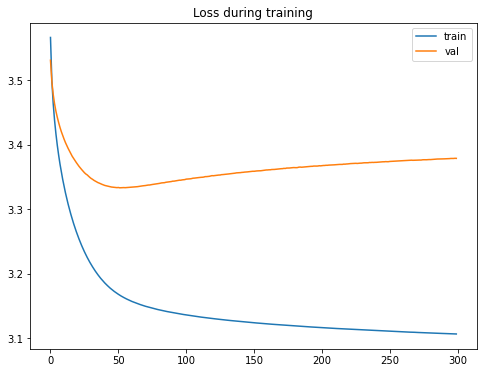

In [25]:
epochs = list(range(300))
fig = plt.figure(figsize=[8,6])
plt.plot(epochs, train_loss_hist, label="train")
plt.plot(epochs, val_loss_hist, label="val")
plt.title("Loss during training")
plt.legend()
plt.show

In [27]:
train_acc_hist_1 = []
for item in train_acc_hist:
    train_acc_hist_1.append(item.cpu())

In [30]:
val_acc_hist_1 = []
for item in val_acc_hist:
    val_acc_hist_1.append(item.cpu())

<function matplotlib.pyplot.show(close=None, block=None)>

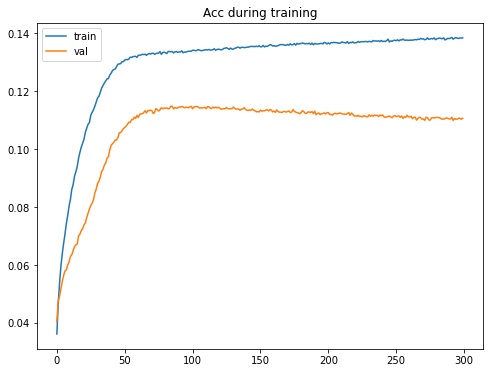

In [32]:
fig = plt.figure(figsize=[8,6])
plt.plot(epochs, train_acc_hist_1, label="train")
plt.plot(epochs, val_acc_hist_1, label="val")
plt.title("Acc during training")
plt.legend()
plt.show